## Imports

In [1]:
import os
import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt

## Parameters and paths

In [2]:
# Define paths
input_dir = "ADM-2024-Assignment-3-data-TPCH-SF-1"
decoded_dir = "decoded_files"
os.makedirs(decoded_dir, exist_ok=True)

# Define compression techniques for each data type category
compression_rules = {
    "integer": ["bin", "rle", "dic", "for", "dif"],
    "string": ["rle", "dic"]
}

# Mapping of file suffixes to categories
data_type_categories = {
    "int8": "integer",
    "int16": "integer",
    "int32": "integer",
    "int64": "integer",
    "string": "string"
}

# Initialize list for storing results
results = []

## Verify data

In [3]:
def run_command(args, stdout=None):
    """Run a shell command and return its output."""
    with subprocess.Popen(args, stdout=stdout if stdout else subprocess.PIPE, stderr=subprocess.PIPE) as process:
        stdout_data, stderr_data = process.communicate()
    return stdout_data, stderr_data, process.returncode

def get_file_size(filepath):
    """Return the size of a file in bytes."""
    return os.path.getsize(filepath) if os.path.isfile(filepath) else None

def encode_and_decode(file, technique, dtype):
    """Encode and decode a file, then log results."""
    file_path = os.path.join(input_dir, file)
    encoded_file = f"{file_path}.{technique}"  # Encoded file is created directly in input folder
    decoded_file = os.path.join(decoded_dir, f"{file}.{technique}.csv")  # Decoded output path

    # Encoding
    start_time = time.time()
    _, _, code = run_command(["./program", "en", technique, dtype, file_path])
    encoding_time = time.time() - start_time
    if code != 0:
        print(f"Encoding failed for {file} with {technique}")
        return None

    # Check file sizes
    original_size = get_file_size(file_path)
    encoded_size = get_file_size(encoded_file)

    # Decoding
    start_time = time.time()
    with open(decoded_file, "w") as f_out:
        _, _, code = run_command(["./program", "de", technique, dtype, encoded_file], stdout=f_out)
    decoding_time = time.time() - start_time
    if code != 0:
        print(f"Decoding failed for {file} with {technique}")
        return None

    decoded_size = get_file_size(decoded_file)

    # Difference check
    diff_cmd = ["diff", file_path, decoded_file]
    _, _, diff_code = run_command(diff_cmd)
    difference = "Yes" if diff_code == 0 else "No"

    # Record results
    results.append({
        "File": file,
        "Technique": technique,
        "Data Type": dtype,
        "Original Size (bytes)": original_size,
        "Encoded Size (bytes)": encoded_size,
        "Decoded Size (bytes)": decoded_size,
        "Encoding Time (s)": encoding_time,
        "Decoding Time (s)": decoding_time,
        "No Difference": difference
    })

# Process each file in the input directory
for file in os.listdir(input_dir):
    if file.endswith(".csv"):
        # Dynamically determine the data type from the filename
        dtype = file.split("-")[-1].replace(".csv", "")
        
        # Check if dtype is known and get its category
        if dtype in data_type_categories:
            category = data_type_categories[dtype]
            applicable_techniques = compression_rules[category]
            
            # Run each applicable compression technique on the file
            for technique in applicable_techniques:
                encode_and_decode(file, technique, dtype)
        else:
            print(f"Unknown data type for file: {file}")

df = pd.DataFrame(results)

### Check if all methods worked

In [7]:
df.to_csv('ExperimentResults.csv')

## Creating visuals

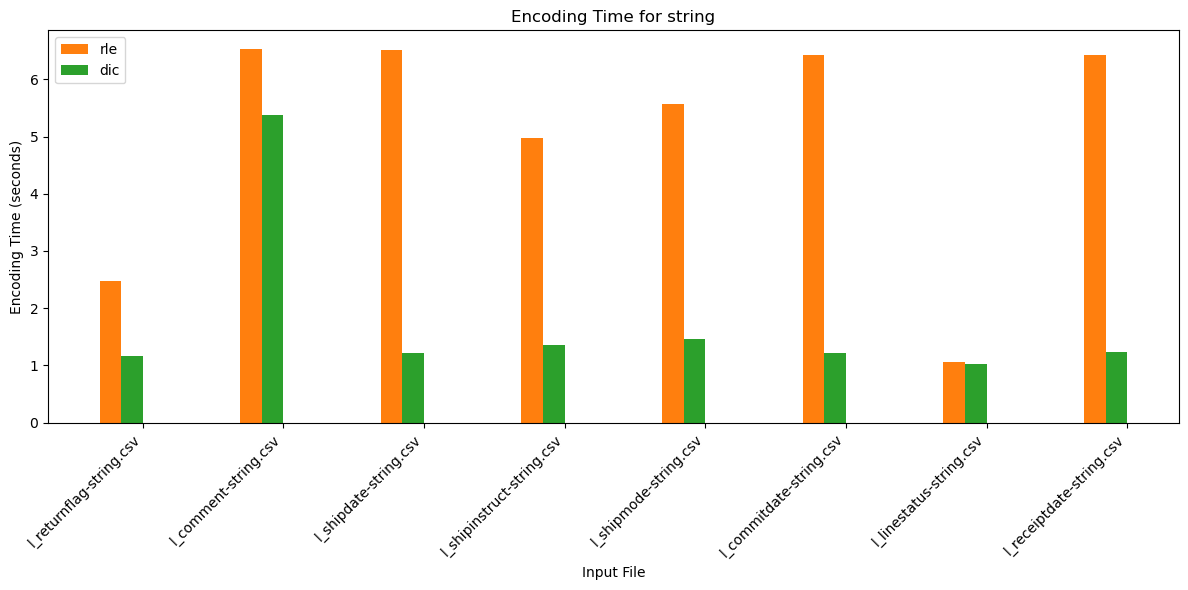

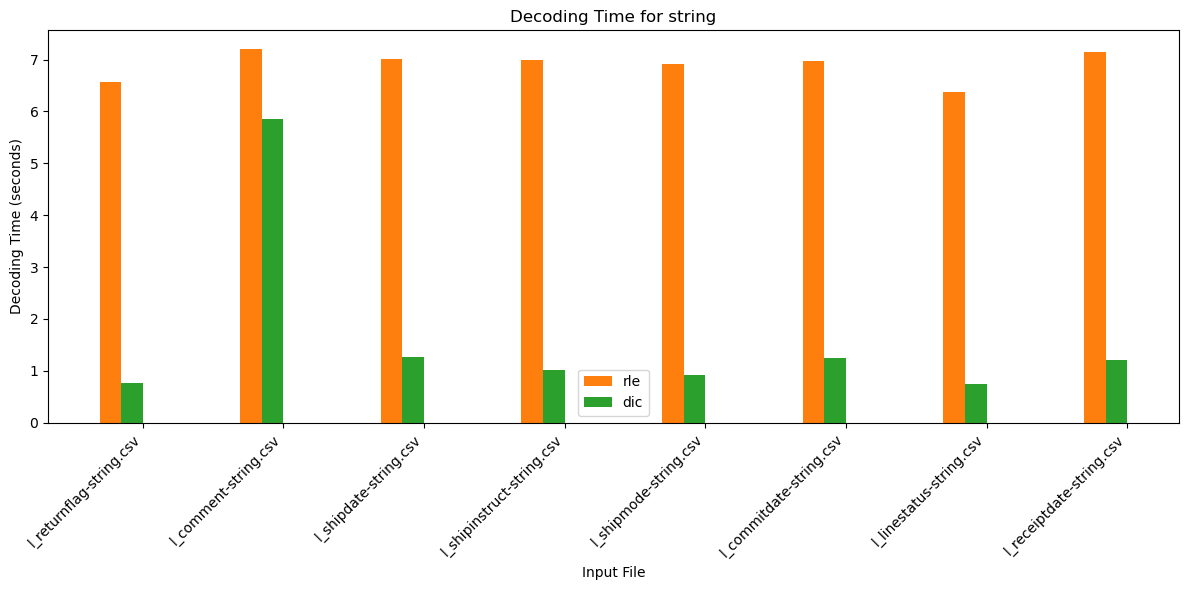

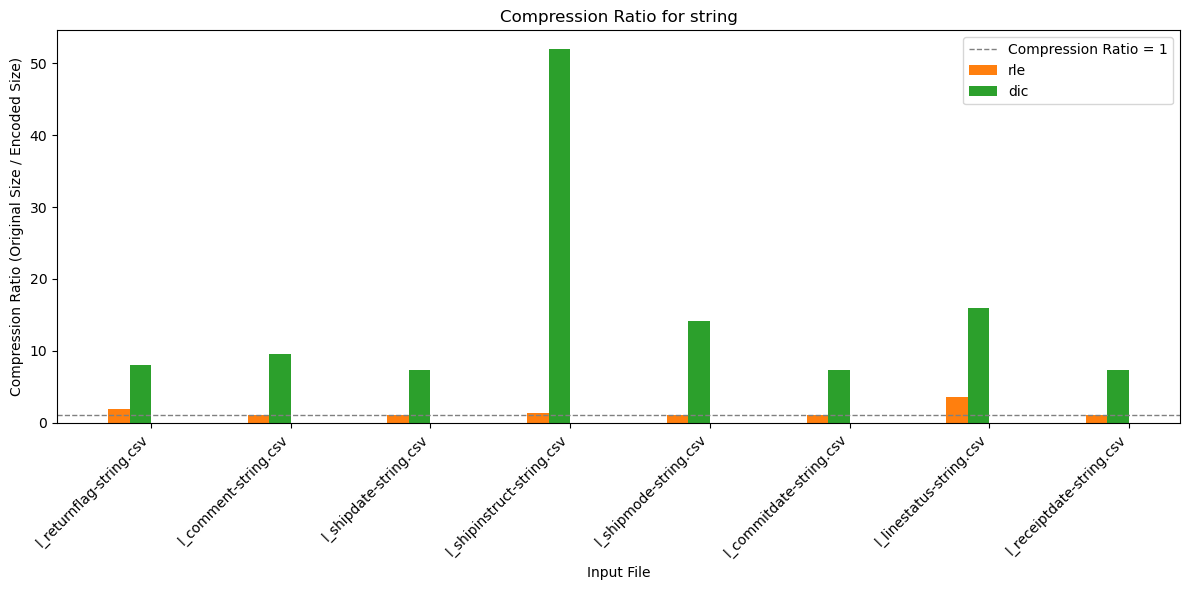

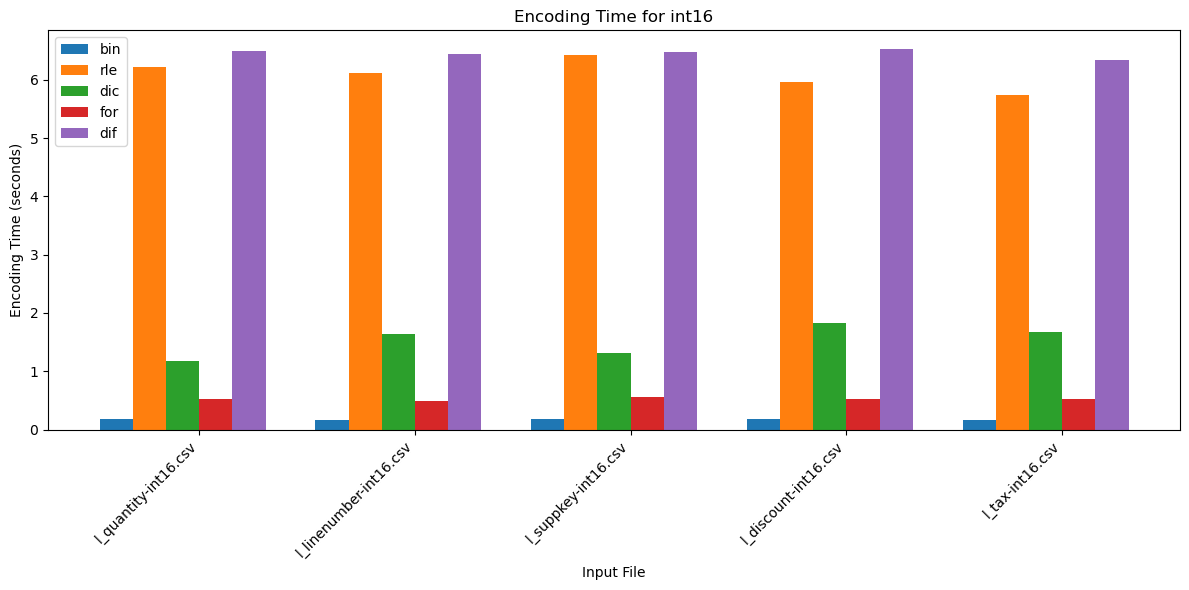

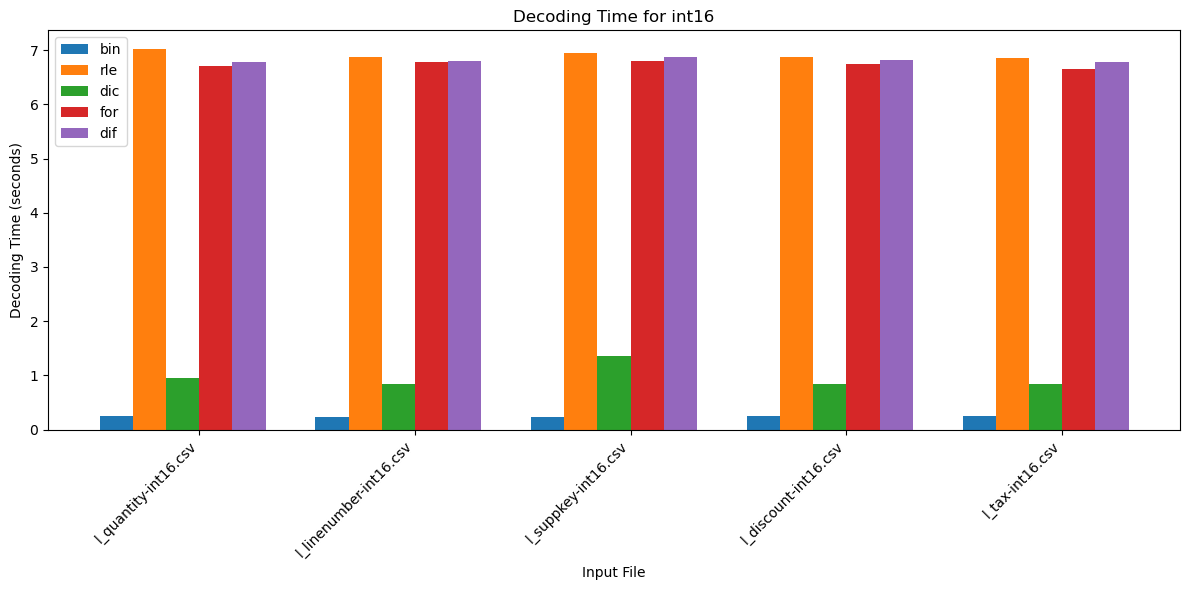

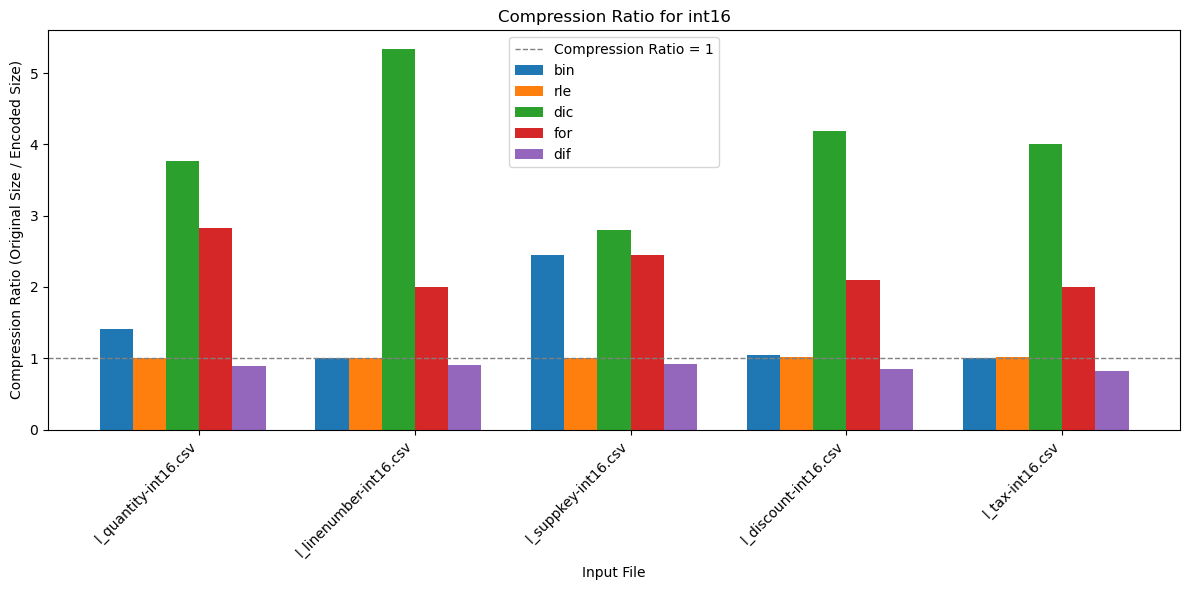

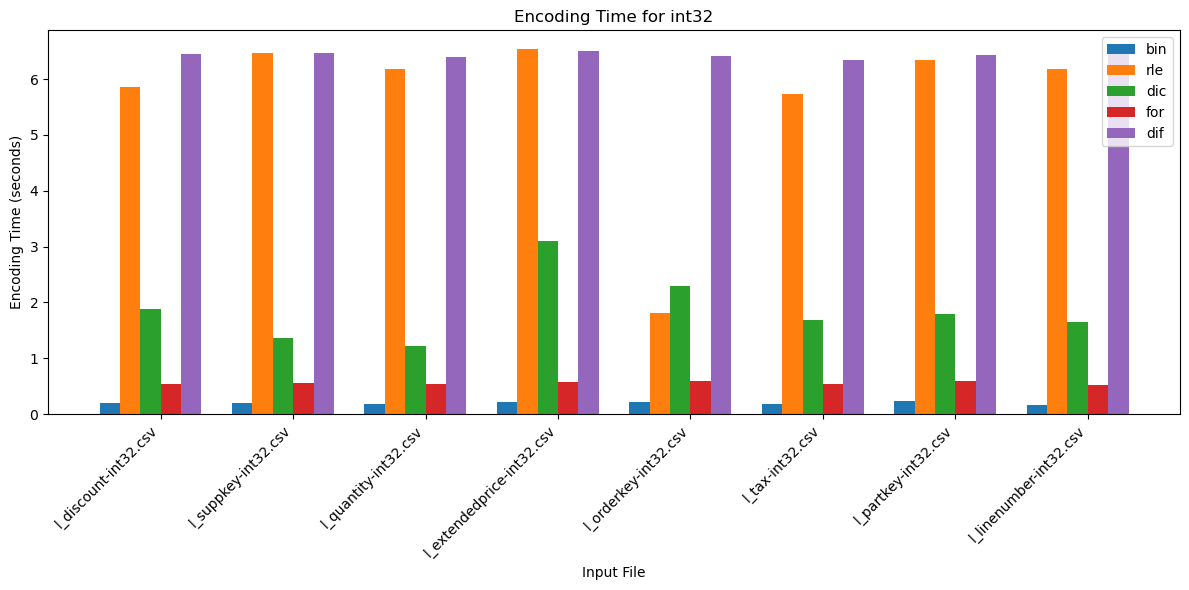

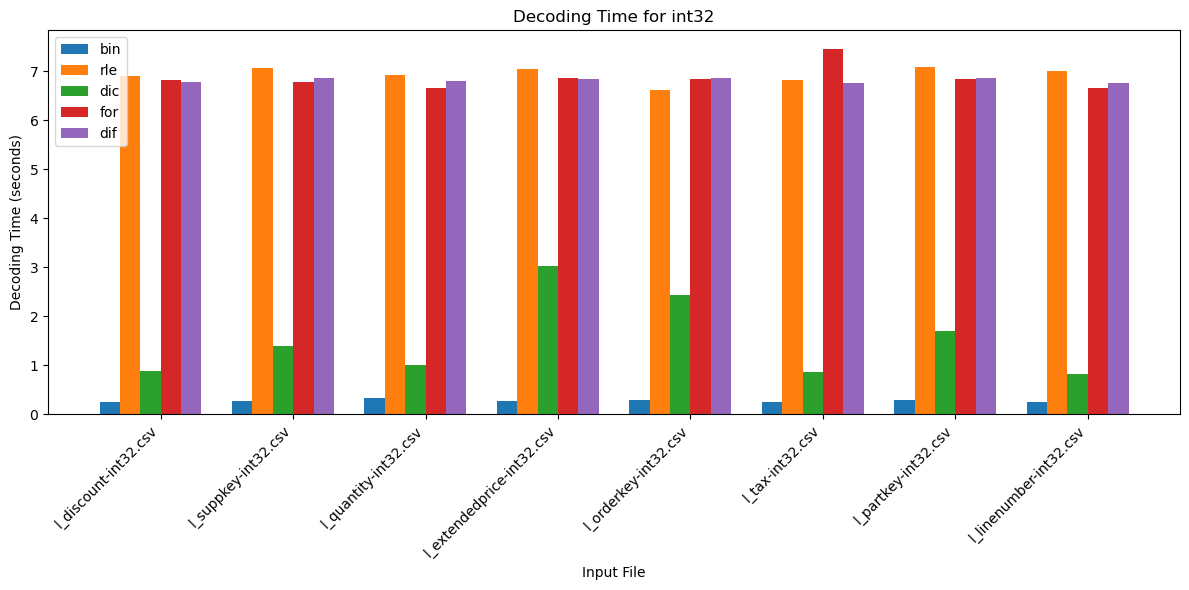

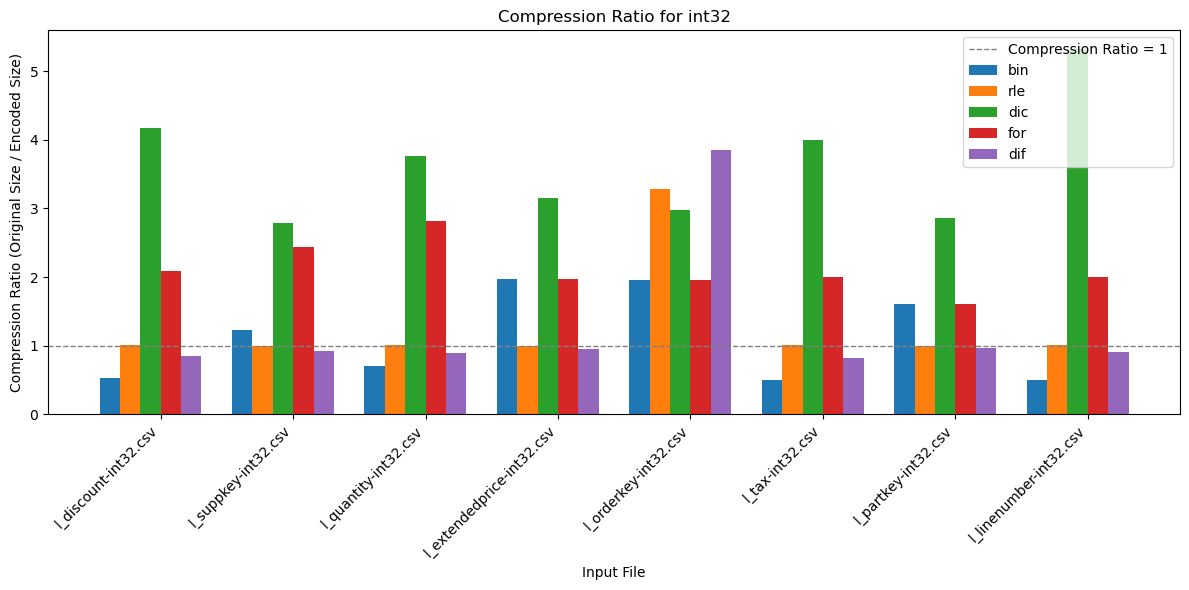

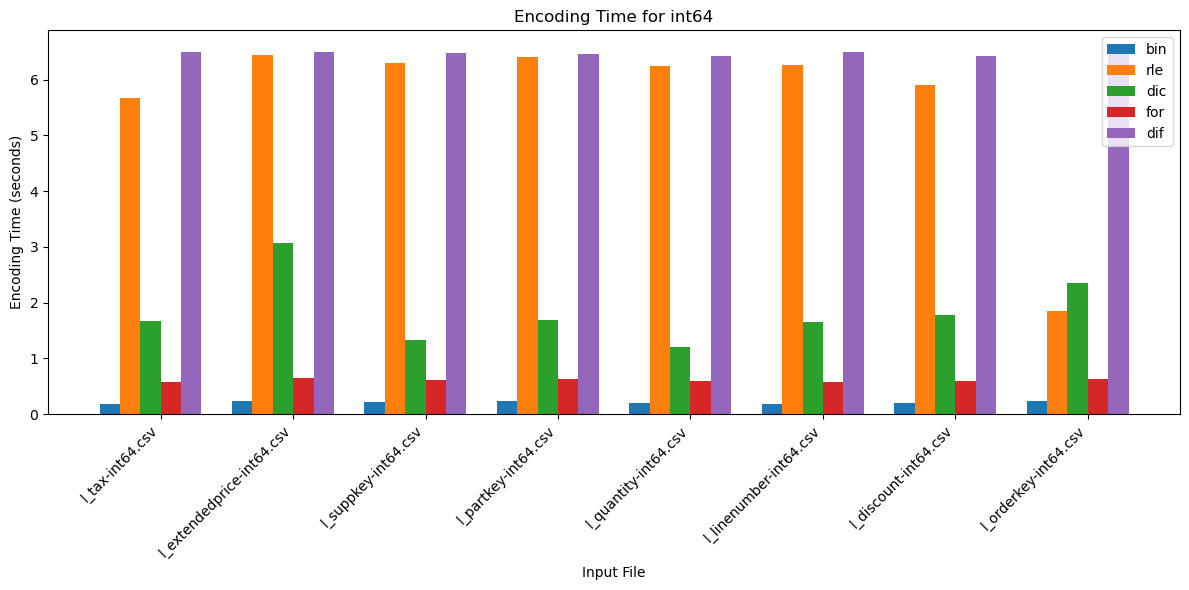

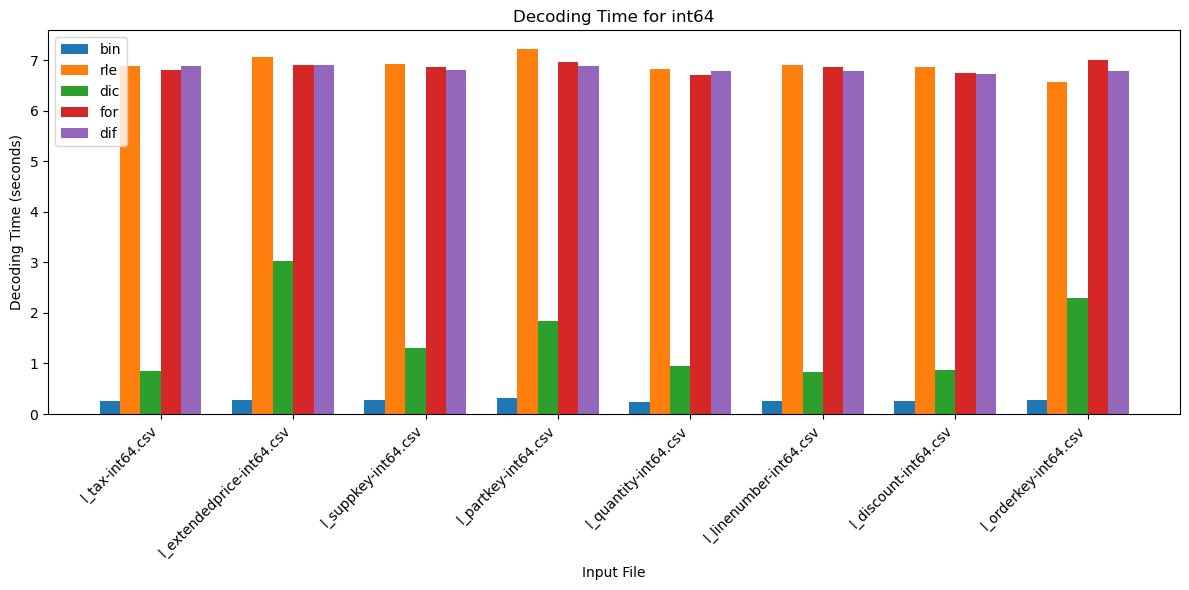

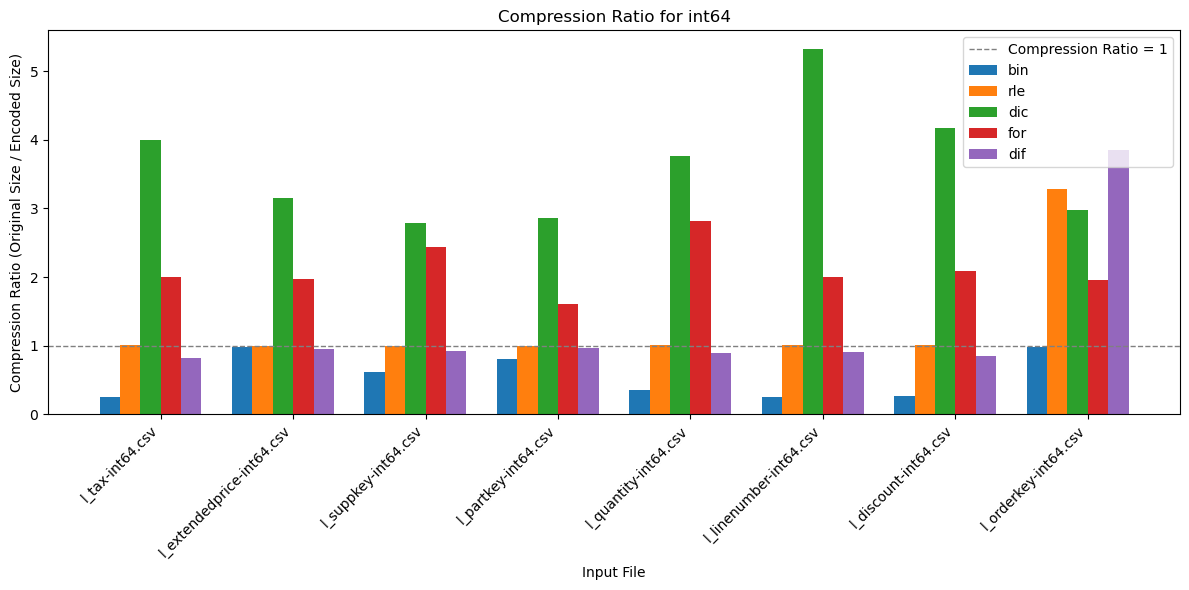

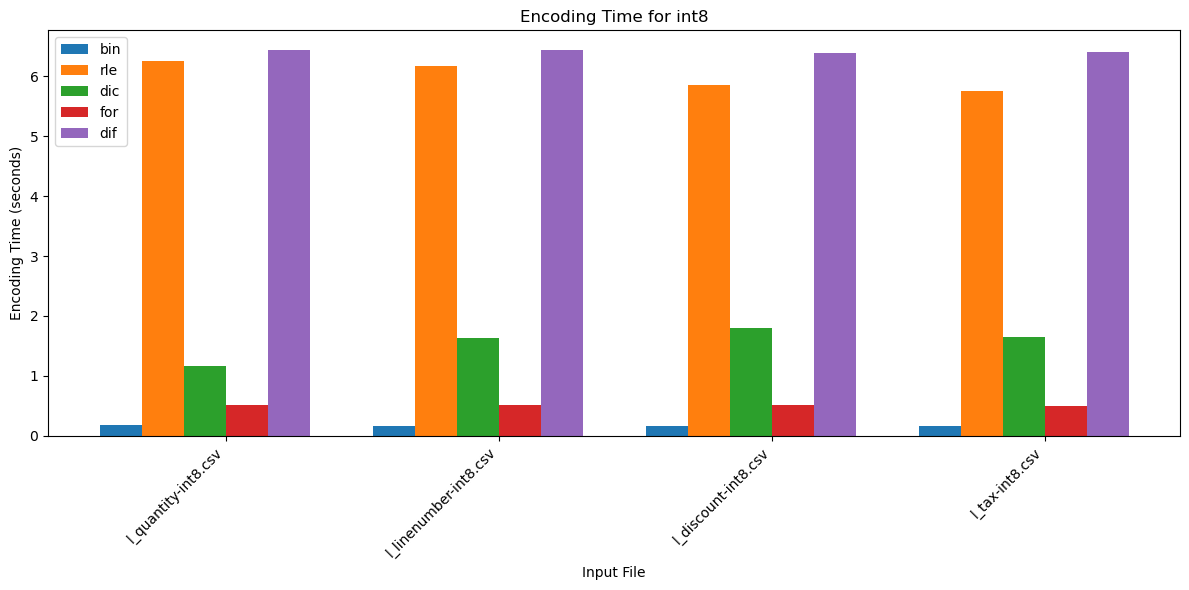

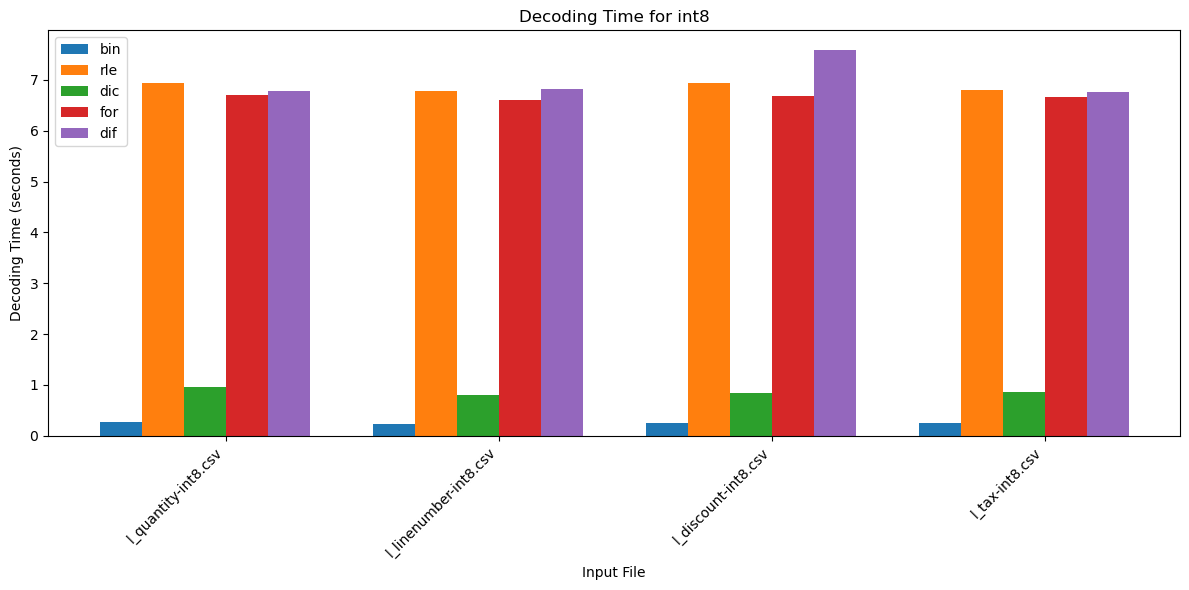

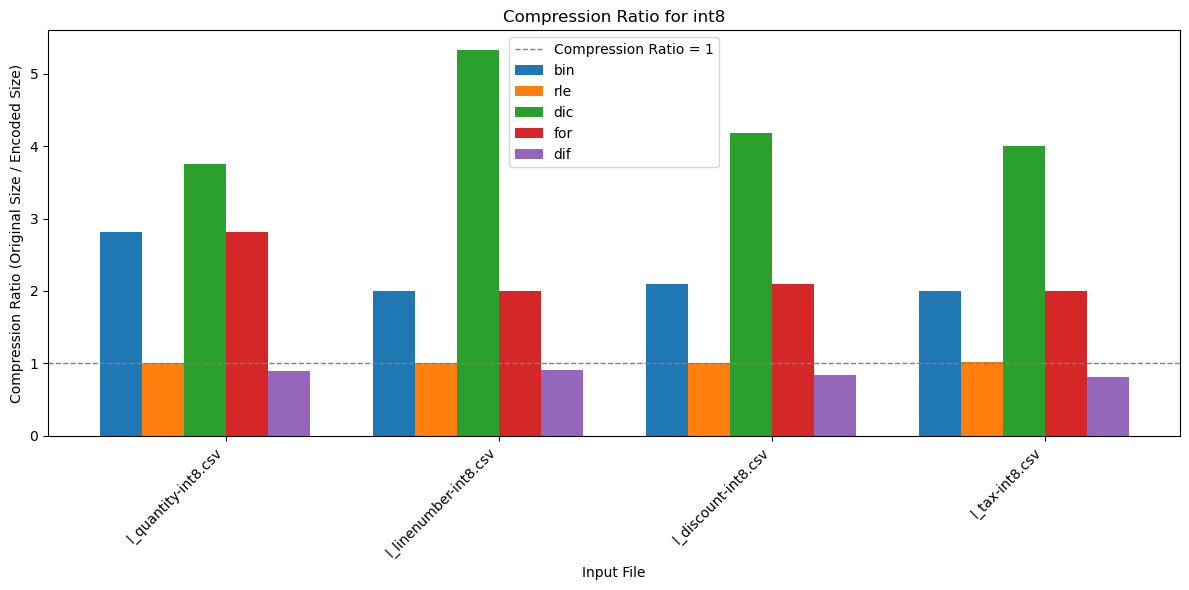

In [11]:
# Calculate Compression Ratio and add it to the DataFrame
df['Compression Ratio'] = df['Original Size (bytes)'] / df['Encoded Size (bytes)']

# Define consistent colors for techniques
technique_colors = {
    "bin": "#1f77b4",
    "rle": "#ff7f0e",
    "dic": "#2ca02c",
    "for": "#d62728",
    "dif": "#9467bd"
}

# Get unique data types
data_types = df['Data Type'].unique()

# Spacing between each group of bars for input files
spacing = 0.3  

# Generate plots
for dtype in data_types:
    dtype_data = df[df['Data Type'] == dtype]
    input_files = dtype_data['File'].unique()
    x = range(len(input_files))

    # Plot 1: Encoding Time with 5 bars per input file for each technique
    plt.figure(figsize=(12, 6))

    for idx, technique in enumerate(technique_colors.keys()):
        subset = dtype_data[dtype_data['Technique'] == technique]
        if not subset.empty:  # Only plot if subset is not empty
            plt.bar([p * (1 + spacing) + idx * 0.2 for p in x], subset['Encoding Time (s)'], width=0.2,
                    label=technique, color=technique_colors[technique])
    
    plt.xlabel('Input File')
    plt.ylabel('Encoding Time (seconds)')
    plt.title(f'Encoding Time for {dtype}')
    plt.xticks([p * (1 + spacing) + (len(technique_colors) / 2) * 0.2 for p in x], input_files, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: Decoding Time with 5 bars per input file for each technique
    plt.figure(figsize=(12, 6))
    for idx, technique in enumerate(technique_colors.keys()):
        subset = dtype_data[dtype_data['Technique'] == technique]
        if not subset.empty:  # Only plot if subset is not empty
            plt.bar([p * (1 + spacing) + idx * 0.2 for p in x], subset['Decoding Time (s)'], width=0.2,
                    label=technique, color=technique_colors[technique])
    
    plt.xlabel('Input File')
    plt.ylabel('Decoding Time (seconds)')
    plt.title(f'Decoding Time for {dtype}')
    plt.xticks([p * (1 + spacing) + (len(technique_colors) / 2) * 0.2 for p in x], input_files, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 3: Compression Ratio with 5 bars per input file for each technique
    plt.figure(figsize=(12, 6))
    for idx, technique in enumerate(technique_colors.keys()):
        subset = dtype_data[dtype_data['Technique'] == technique]
        if not subset.empty:  # Only plot if subset is not empty
            plt.bar([p * (1 + spacing) + idx * 0.2 for p in x], subset['Compression Ratio'], width=0.2,
                    label=technique, color=technique_colors[technique])
    
    # Add a dashed line at y=1 for Compression Ratio
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='Compression Ratio = 1')
    plt.xlabel('Input File')
    plt.ylabel('Compression Ratio (Original Size / Encoded Size)')
    plt.title(f'Compression Ratio for {dtype}')
    plt.xticks([p * (1 + spacing) + (len(technique_colors) / 2) * 0.2 for p in x], input_files, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()